# Exploring the use of Animal Faces dataset

### Importing basic packages
<code style="color:darkblue">
- numpy: computiong library for large/multidimensioanl array & functions
- pandas: data analysis & data manipulation</code>

<code style="color:darkblue">**For AI modeling there are two main libraries:**
    - Tensoflow -> Google brain
    - Pytorch -> Meta AI
**Here, I am also adding all the necessary libraries for this project.**
</code>

In [1]:
import numpy as np #numpy library, used for working with arrays
import pandas as pd #pandas library, used for data manipulation & analysis
import tensorflow as tf #tensorflow library, used for machine learning & neural networks
import torch as pt #PyTorch library, another library used for machine learning
import os #os library, provides functions for interacting with the operating system
import matplotlib.pyplot as plt #matplotlib library, used for creating static, animated, & interactive visualizations
import seaborn as sns #seaborn library, Python data visualization library based on matplotlib
from tensorflow import keras #allows easy & fast prototyping & supports both convolutional networks & recurrent networks

2024-04-14 23:05:33.369800: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-14 23:05:33.369914: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-14 23:05:33.485055: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<code style="color:darkblue">**Checking tensorflow & torch versions**
    - I know that this part is not mandatory to be written here but i still put it.
</code>

In [2]:
print("Tensorflow version: " + tf.__version__) #print Tensorflow version
print("PyTorch version: " + pt.__version__) #print PyTorch version

Tensorflow version: 2.15.0
PyTorch version: 2.1.2


***
# Importing a dataset from Kaggle

<code style="color:darkblue">In every train dataset cat & dog we have around 821 pictures that are called flickr_cat or flickr_dog and around 4834 pixabay_cat or pixabay_dog. Overall in the dataset I have around 5655 images for cat & around 5655 images for dog. Every image has 512×512 resolution. </code>

In [3]:
from PIL import Image #importing the Image module from PIL, which provides image processing capabilities
from tensorflow.keras import datasets, layers, models #used for building & training
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img #used for real-time data augmentation & loading images

In [4]:
src_dirs = ['/kaggle/input/animal-faces/afhq/train/cat', #source directory for cat images in training dataset
            '/kaggle/input/animal-faces/afhq/train/dog', #source directory for dog images in training dataset
            '/kaggle/input/animal-faces/afhq/val/cat', #source directory for cat images in validation dataset
            '/kaggle/input/animal-faces/afhq/val/dog'] #source directory for dog images in validation dataset
dst_dir = '/kaggle/working/' #destination directory for processed data

In [5]:
os.makedirs(dst_dir, exist_ok=True) #to create destination directory if it doesn't exist already
dir_path = '/kaggle/working/' #define directory path
items = os.listdir(dir_path) #list all items in the directory
for item in items: #iterate over all items
    if os.path.isdir(os.path.join(dir_path, item)): #check if item is directory
        print(item) #print directory name

***
# Train the data

In [6]:
train_dir = '/kaggle/input/animal-faces/afhq/train' #train set
test_dir = '/kaggle/input/animal-faces/afhq/val' #test set

In [7]:
if os.path.isdir(train_dir) and os.path.isdir(test_dir): #cheking if the directories for training & dataset exist
    #rescaling the image by 1/255to normalize the pixel values
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True)
    test_datagen = ImageDataGenerator(rescale=1./255) #create an ImageDataGenerator for the testing data
training_set = train_datagen.flow_from_directory(train_dir,target_size=(64, 64),batch_size=32,class_mode='binary') #loading the images from the training directory
test_set = test_datagen.flow_from_directory(test_dir,target_size=(64, 64),batch_size=32,class_mode='binary') #loading the images from the set directory
print(f'Number of samples in the validation set: {len(test_set)}') #printing the numbers of samples in the validation set

Found 14630 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Number of samples in the validation set: 47


***
# Building the Convolutional Neural Networks (CNNs) model

In [8]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions #importing the VGG16 model, preprocess_input function & decode_predictions function from keras
from keras.preprocessing import image #importing the image module from keras
from tensorflow.keras.layers import Dropout, Flatten, Dense #importing dropout layer from keras
from tensorflow.keras.optimizers import Adam #importing adam optimizer from keras
from keras.layers import InputLayer #importing InputLayer from keras, usesd to instantiate Keras tensor
from keras.layers import ZeroPadding2D #imporsting ZeroPadding2D from keras, used for 2D spatial zero-padding
from keras.optimizers import RMSprop #importing RMSprop optimizer from keras
from sklearn.model_selection import train_test_split #importing the train_test_split function from sklearn's model_selection module
from keras.utils import to_categorical #importing the to_categorical function from keras' utils module
from keras.models import Sequential #importing the Sequential model from keras' models module
from keras.callbacks import ReduceLROnPlateau #importing ReduceLROnPlateau from keras.callbacks, function used in training the model

In [9]:
model = models.Sequential() #creating sequential model
img_size = 64 #define image size as 64x64 pixels
model.add(layers.Normalization()) #add normalization layer to normalize the input data
model.add(InputLayer(input_shape=(img_size, img_size, 1))) #add input layer with the shape of input data
model.add(ZeroPadding2D((3, 3))) #add zero padding layer to pad the input with zeros around the border
model.add(layers.Conv2D(64, (4, 4), padding='same', activation='relu', input_shape=(64, 64, 3))) #adding first convolutional layer with 32 layers, kernel size 3x3 & activation function & input shape of 64x64x3
model.add(layers.BatchNormalization()) #normalizing the inputs of the layer
model.add(layers.MaxPooling2D((2, 2), strides=(3, 3))) #add max pooling layer to reduce the spatial dimensions of the output volume
model.add(layers.Conv2D(128, (5, 5), padding='same', activation='relu')) #adding second convolutional layer with 64 layers & kernels size 3x3
model.add(layers.BatchNormalization()) #normalizing the inputs of the layer
model.add(layers.MaxPooling2D((2, 2), strides=(3, 3))) #add max pooling layer to reduce the spatial dimensions of the output volume
model.add(layers.Conv2D(128, (5, 5), padding='same', activation='relu')) #adding third convolutional layer with 64 layers & kernels size 3x3
model.add(layers.BatchNormalization()) #normalizing the inputs of the layer
model.add(Dropout(0.5)) #dropout layer
model.add(Flatten()) #flatten the tensor output by the convolutional layers
model.add(layers.Dense(64, activation='relu')) #actiavtion='relu' -> function returns x if x is greater than 0, & returns 0 otherwise
model.add(layers.Dense(32, activation='sigmoid')) #adding dense layer with 32 neurons & sigmoid activation function
model.add(Dense(128,activation="relu")) #adding dense layer with 128 neurons & ReLU activation function
model.add(Dense(3, activation="softmax")) #adding a dense layer with 3 neurons & softmax activation function to output probabilities
#dense layer or connected layer is type of layer in neural network where each neuron is connected to every neuron in the preceding layer
model.add(layers.Dense(1, activation='sigmoid')) 
model.build(input_shape=(None, img_size, img_size, 1)) #bulding the model with specific input shape
model.summary() #prints summary representation of the model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 64, 64, 1)         3         
 on)                                                             
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 zero_padding2d (ZeroPaddin  (None, 70, 70, 1)         0         
 g2D)                                                            
                                                                 
 conv2d (Conv2D)             (None, 70, 70, 64)        1088      
                                                                 
 batch_normalization (Batch  (None, 70, 70, 64)        256       
 Normalization)                                                  
                                                        

In [10]:
model.compile(optimizer='adam', #the 'adam' part is opotimizer for the training process
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [11]:
#defining paths for 4 images
img1 = "../input/animal-faces/afhq/train/cat/flickr_cat_000003.jpg"
img2 = "../input/animal-faces/afhq/train/dog/flickr_dog_000009.jpg"
img3 = "../input/animal-faces/afhq/train/cat/flickr_cat_000005.jpg"
img4 = "../input/animal-faces/afhq/train/dog/flickr_dog_000002.jpg"
imgs = [img1, img2, img3, img4] #list of image paths
#function to load & preprocess the images
def _load_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224)) #loading images with 224x224 pixels
    img = image.img_to_array(img) #converting the image to an array
    img = np.expand_dims(img, axis=0) #expanding the dimensions of the image
    img = preprocess_input(img) #preprocess the image
    return img
def _get_predictions(_model): #function to get predictions from a model
    f, ax = plt.subplots(1, 4) #subploat with 1 row & 4 columns
    f.set_size_inches(80, 40) #size of the figure
    for i in range(4):
        ax[i].imshow(Image.open(imgs[i]).resize((100, 100), Image.ANTIALIAS)) #resize the image & display it on the subploat
    plt.show() #show the plot
    f, axes = plt.subplots(1, 4) #create another subplot for the precistions
    f.set_size_inches(80, 20) #set the size of the figure
    labels = ['cat', 'dog', 'other'] #defining labels
    for i,img_path in enumerate(imgs):
        img = _load_image(img_path) #load & preprocess the image
        preds  = decode_predictions(_model.predict(img), top=3)[0] #getting tohe best 3 predictions from the model
        #changing the labels of the predictions
        for j in range(3):
            preds[j] = (preds[j][0], labels[j], preds[j][2])
        b = sns.barplot(y=[c[1] for c in preds], x=[c[2] for c in preds], color="blue", ax=axes[i]) #creating bar plot of the predictions
        b.tick_params(labelsize=55) #setting size of the tick labels
        f.tight_layout() #adjust layout of the figure

553467096/553467096 [==============================] - 2s 0us/step


/tmp/ipykernel_26/3962453908.py:18: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  ax[i].imshow(Image.open(imgs[i]).resize((100, 100), Image.ANTIALIAS)) #resize the image & display it on the subploat


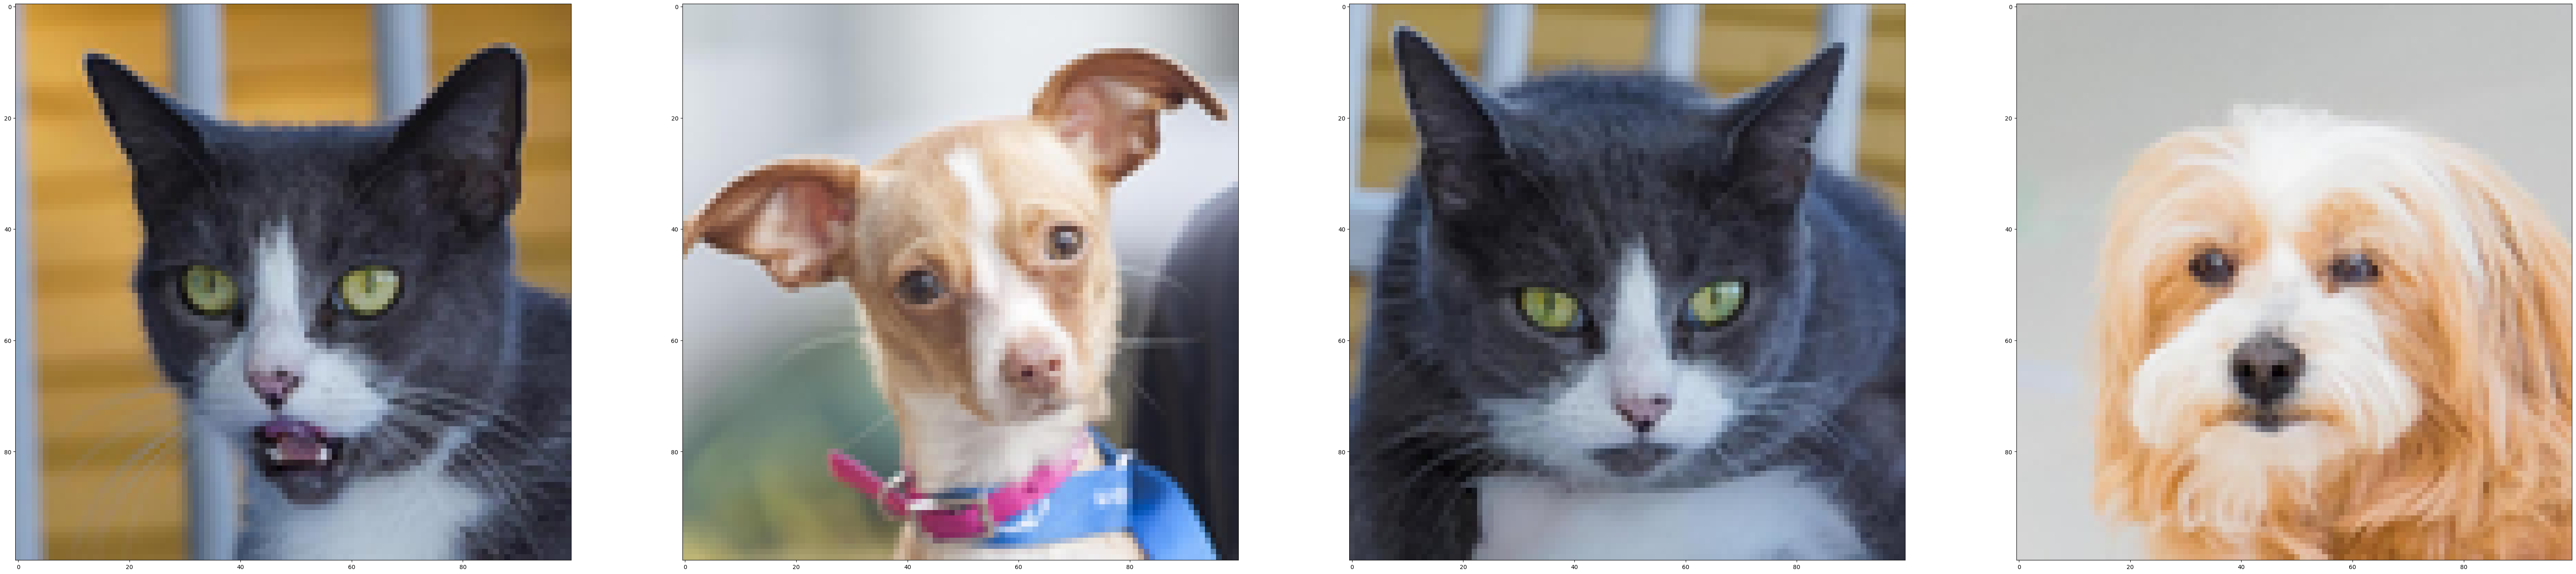

35363/35363 [==============================] - 0s 0us/step


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


1/1 [==============================] - 0s 19ms/step


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


1/1 [==============================] - 0s 18ms/step


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


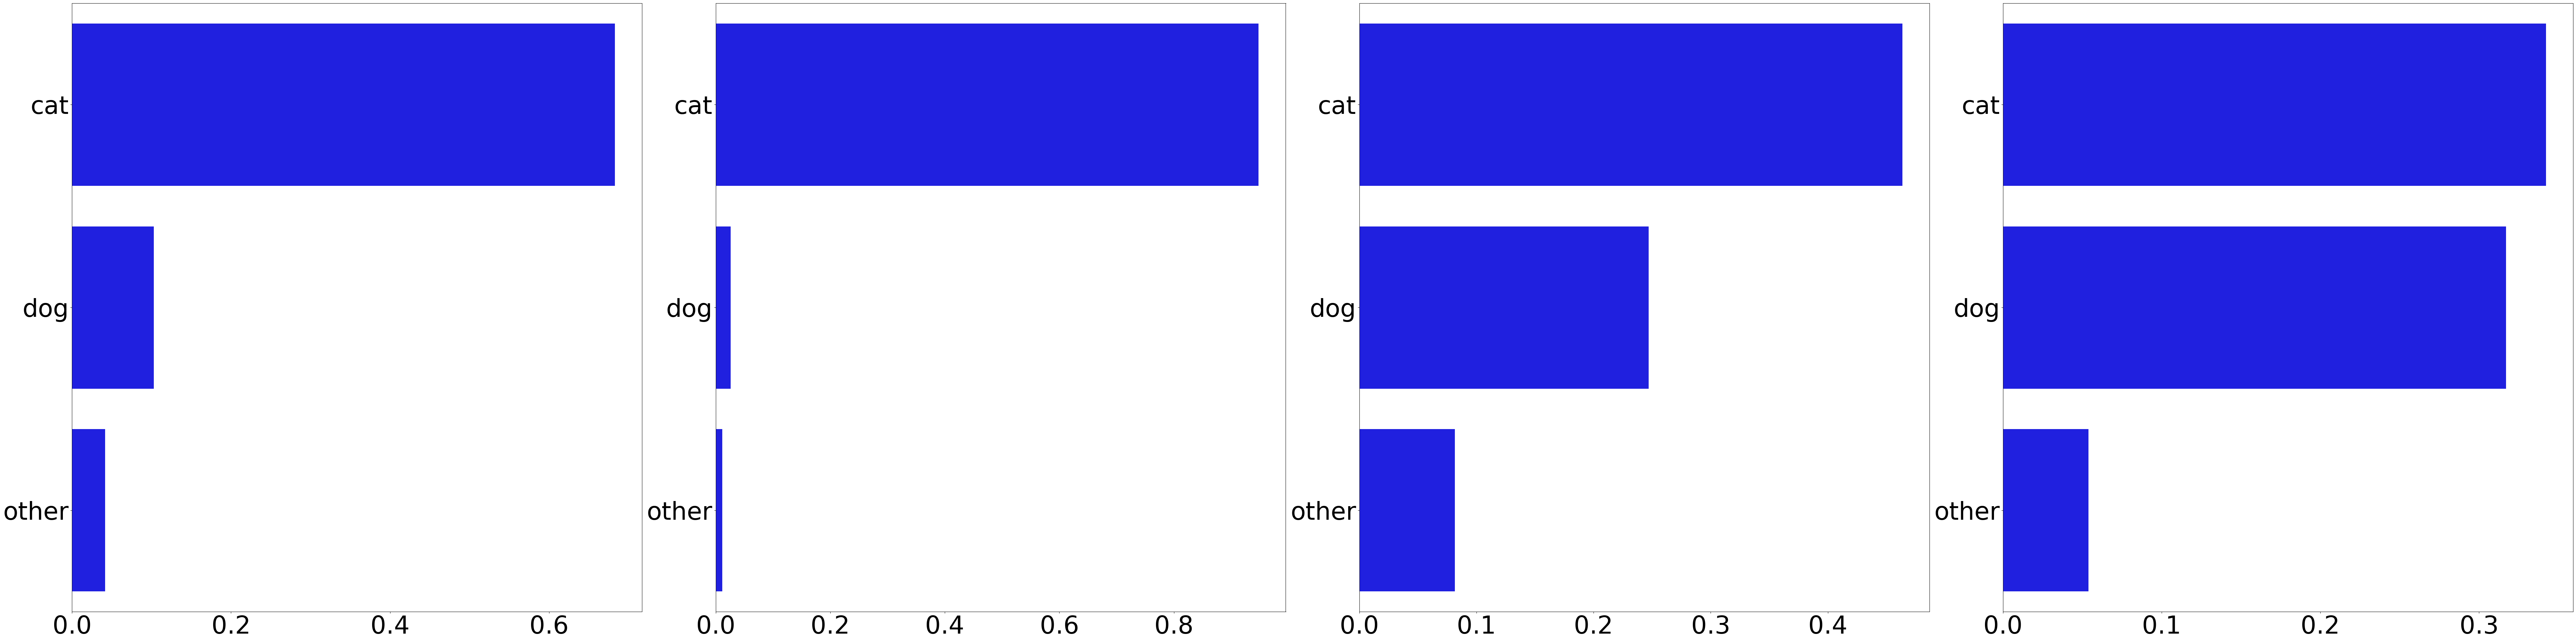

In [12]:
vgg16_model = VGG16(weights='imagenet') #loading VGG16 model with pre-trained weights from the ImageNet dataset
_get_predictions(vgg16_model) #function to get prdictions from the VGG16 model

In [13]:
num_classes = 5 #number of classes for the classification problem
X_train = np.random.rand(100000, 100) #generating a 2D numpy array 'X_train' with 100000 rows & 100 columns
y_train = np.random.randint(0, num_classes, size=100000) #generating a 1D numpy array 'y_train' with 100000 elements
if len(X_train) < 2: 
    print("Dataset is too small to split. Proceeding without splitting.")
    X_val, y_val = X_train, y_train
else:
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42) #80% of the data is used for training & 20% is used for validation
y_train_one_hot = to_categorical(y_train, num_classes) #multi-class classification in Keras
y_val_one_hot = to_categorical(y_val, num_classes) #converting the validation labels into one-hot vectors
input_shape = X_train.shape[1] #defining input shape based on the training data
#converting training & validation labels to one_hot encoding
y_train_one_hot = to_categorical(y_train, num_classes=num_classes) 
y_val_one_hot = to_categorical(y_val, num_classes=num_classes) 
model = Sequential([ #defining model architecture
    Dense(128, activation='relu', input_shape=(input_shape,)), #first dense layer with 128 units & ReLU activation
    Dropout(0.5), #applying dropout to prevent overfitting
    Dense(64, activation='relu'), #second dense layer with 64 units & ReLU activation
    Dropout(0.5), #applying dropout to prevent overfitting
    Dense(num_classes, activation='softmax') #output layer with 'num_classes' units & softmax activation for multi-class classification
])
optimizer = Adam(lr=0.001) #defining optimizer with a learning rate of 0.001
#compiling model with the defined optimizer, loss function & metrics
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5) #defining a learning rate scheduler that reduces the learning rate when the validation loss plateaus
#training model on the training data & validate on the validation data
history = model.fit(X_train, 
                    y_train_one_hot, 
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val_one_hot))

Epoch 1/10


I0000 00:00:1713135978.484313      86 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2500/2500 [==============================] - 11s 3ms/step - loss: 1.6136 - accuracy: 0.1997 - val_loss: 1.6094 - val_accuracy: 0.2016
Epoch 2/10
2500/2500 [==============================] - 8s 3ms/step - loss: 1.6097 - accuracy: 0.2005 - val_loss: 1.6096 - val_accuracy: 0.1975
Epoch 3/10
2500/2500 [==============================] - 8s 3ms/step - loss: 1.6096 - accuracy: 0.2000 - val_loss: 1.6096 - val_accuracy: 0.1973
Epoch 4/10
2500/2500 [==============================] - 8s 3ms/step - loss: 1.6096 - accuracy: 0.1983 - val_loss: 1.6095 - val_accuracy: 0.1972
Epoch 5/10
2500/2500 [==============================] - 8s 3ms/step - loss: 1.6096 - accuracy: 0.1971 - val_loss: 1.6095 - val_accuracy: 0.1978
Epoch 6/10
2500/2500 [==============================] - 8s 3ms/step - loss: 1.6096 - accuracy: 0.2012 - val_loss: 1.6095 - val_accuracy: 0.1973
Epoch 7/10
2500/2500 [==============================] - 8s 3ms/step - loss: 1.6095 - accuracy: 0.1998 - val_loss: 1.6097 - val_accuracy: 0.2007
Ep

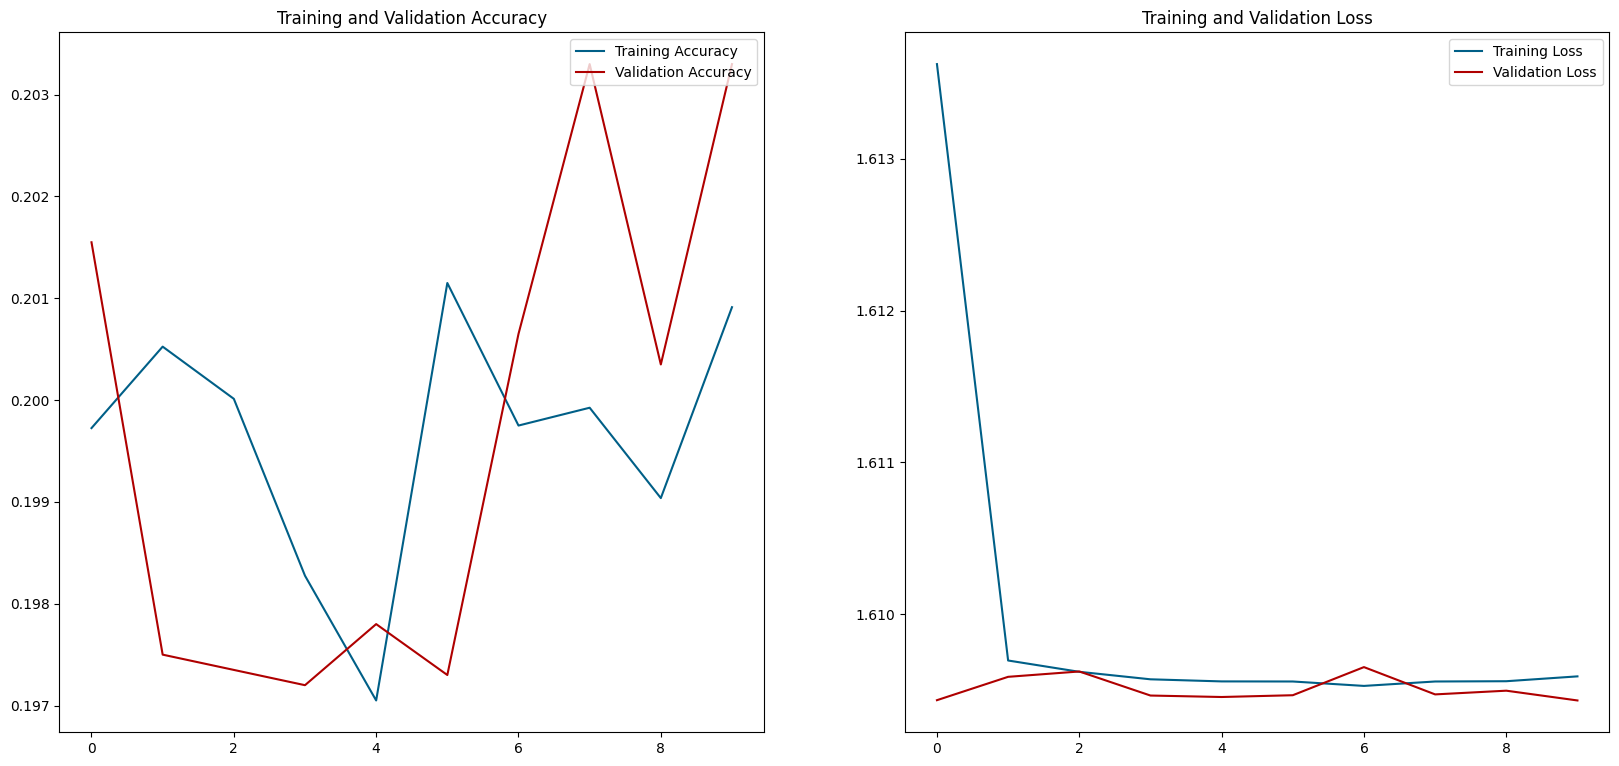

In [14]:
acc = history.history['accuracy'] #extract the accuracy history from the model's training history
val_acc = history.history['val_accuracy'] #extract the validation accuracy history from the model's training history
loss = history.history['loss'] #extract the loss history from the model's training history
val_loss = history.history['val_loss'] #extract the validation loss history from the model's training history
epochs_range = range(len(acc)) #represents number of epochs for which the model was trained
plt.figure(figsize=(20, 20)) #creating new figure for plotting
plt.subplot(2, 2, 1) #adding subplot for training & validation accuracy

#plot for training accuracy
plt.plot(epochs_range, 
         acc, label='Training Accuracy', 
         color='#005f87')
        
#plot for validation accuracy
plt.plot(epochs_range, 
         val_acc, 
         label='Validation Accuracy', 
         color='#af0000')
plt.legend(loc='upper right') #adding legend at the upper right of the plot
plt.title('Training and Validation Accuracy') #adding title to the plot
plt.subplot(2, 2, 2) #adding subplot for training & validation loss

#plot for training loss
plt.plot(epochs_range, 
         loss, 
         label='Training Loss', 
         color='#005f87')
        
#plot for validation loss
plt.plot(epochs_range, 
        val_loss, 
        label='Validation Loss', 
        color='#af0000')
plt.legend(loc='upper right') #adding legend at the upper right of the plot
plt.title('Training and Validation Loss') #adding title to the plot
plt.show() #displaying the plots for accuracy & loss